# Seismic Data Compression

```{article-info}
:author: Altay Sansal
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
:class-container: sd-p-0 sd-outline-muted sd-rounded-3 sd-font-weight-light
```

In this page we will be showing compression performance of _MDIO_.

For demonstration purposes, we will use one of the Volve dataset stacks.
The dataset is licensed by Equinor and Volve License Partners under Equinor Open Data Licence.
License document and further information can be found [here](https://www.equinor.com/energy/volve-data-sharing).

We are using the 3D seismic stack dataset named `ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy`.

However, for convenience, we renamed it to `volve.segy`.

```{warning}
The examples below need the following extra dependencies:
1. [Matplotlib](https://matplotlib.org/) for plotting.
2. [Scikit-image](https://scikit-image.org/) for calculating metrics.

Please install them before executing using `pip` or `conda`.
```

```{note}
Even though we demonstrate with Volve here, this notebook can be run with any seismic dataset.
```

If you are new to _MDIO_ we recommend you first look at our [quick start guide](quickstart.ipynb)

In [1]:
from mdio import segy_to_mdio, MDIOReader

## Ingestion

We will ingest three files:

1. Lossless mode
2. Lossy mode (with default tolerance)
3. Lossy mode (with more compression, more relaxed tolerance)

### Lossless (Default)

In [2]:
segy_to_mdio(
    "volve.segy",
    "volve.mdio",
    (189, 193),
    # lossless=True,
    # compression_tolerance=0.01,
)

print("Done.")

Scanning SEG-Y for geometry attributes:   0%|          | 0/6 [00:00<?, ?block/s]

Ingesting SEG-Y in 24 chunks:   0%|          | 0/24 [00:00<?, ?block/s]

Done.


### Lossy Default
Equivalent to `tolerance = 0.01`.

In [3]:
segy_to_mdio(
    "volve.segy",
    "volve_lossy.mdio",
    (189, 193),
    lossless=False,
    # compression_tolerance=0.01,
)

print("Done.")

Scanning SEG-Y for geometry attributes:   0%|          | 0/6 [00:00<?, ?block/s]

Ingesting SEG-Y in 24 chunks:   0%|          | 0/24 [00:00<?, ?block/s]

Done.


### Lossy+ (A Lot of Compression)
Here we set `tolerance = 1`. This means all our errors will be comfortably under 1.0.

In [4]:
segy_to_mdio(
    "volve.segy",
    "volve_lossy_plus.mdio",
    (189, 193),
    lossless=False,
    compression_tolerance=1,
)

print("Done.")

Scanning SEG-Y for geometry attributes:   0%|          | 0/6 [00:00<?, ?block/s]

Ingesting SEG-Y in 24 chunks:   0%|          | 0/24 [00:00<?, ?block/s]

Done.


### Observe Sizes

Since _MDIO_ uses a hierarchical directory structure, we provide a convenience function to get
size of it using directory recursion and getting size.

In [5]:
import os


def get_dir_size(path: str) -> int:
    """Get size of a directory recursively."""
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total


def get_size(path: str) -> int:
    """Get size of a folder or a file."""
    if os.path.isfile(path):
        return os.path.getsize(path)

    elif os.path.isdir(path):
        return get_dir_size(path)


print(f"SEG-Y:\t{get_size('volve.segy') / 1024 / 1024:.2f} MB")
print(f"MDIO:\t{get_size('volve.mdio') / 1024 / 1024:.2f} MB")
print(f"Lossy:\t{get_size('volve_lossy.mdio') / 1024 / 1024:.2f} MB")
print(f"Lossy+:\t{get_size('volve_lossy_plus.mdio') / 1024 / 1024:.2f} MB")

SEG-Y:	1305.02 MB
MDIO:	998.80 MB
Lossy:	263.57 MB
Lossy+:	52.75 MB


## Open Files, and Get Raw Statistics

In [6]:
lossless = MDIOReader("volve.mdio")
lossy = MDIOReader("volve_lossy.mdio")
lossy_plus = MDIOReader("volve_lossy_plus.mdio")

stats = lossless.stats
std = stats["std"]
min_ = stats["min"]
max_ = stats["max"]

## Plot Images with Differences

Let's define some plotting functions for convenience.

Here, we will make two plots showing data for lossy and lossy+ versions.

We will be showing the following subplots for each dataset:
1. Lossless Inline
2. Lossy Inline
3. Difference
4. 1,000x Gained Difference

We will be using ± 3 * standard_deviation of the colorbar ranges.

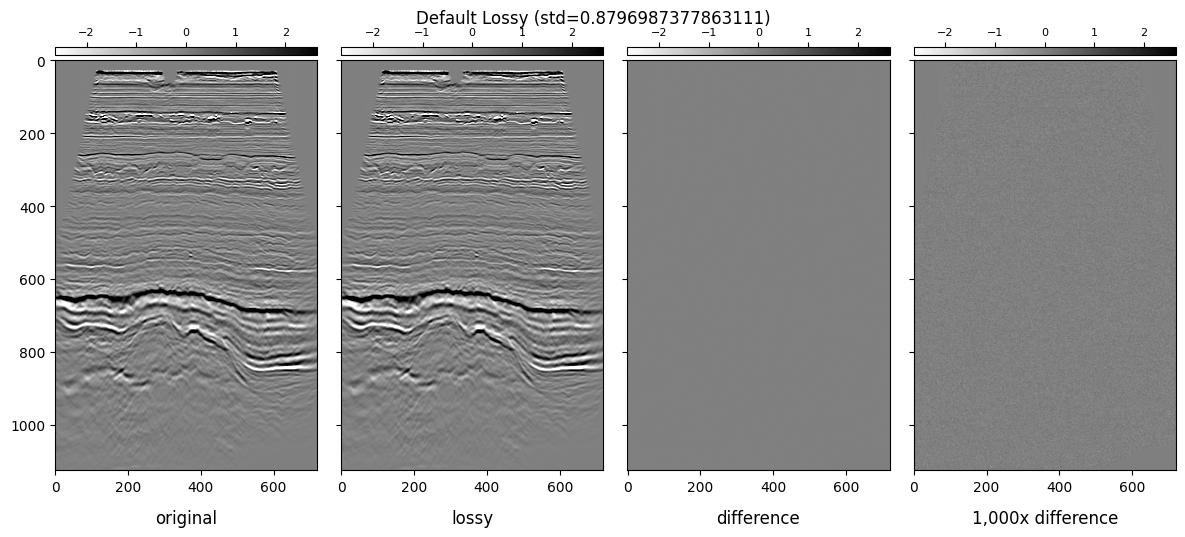

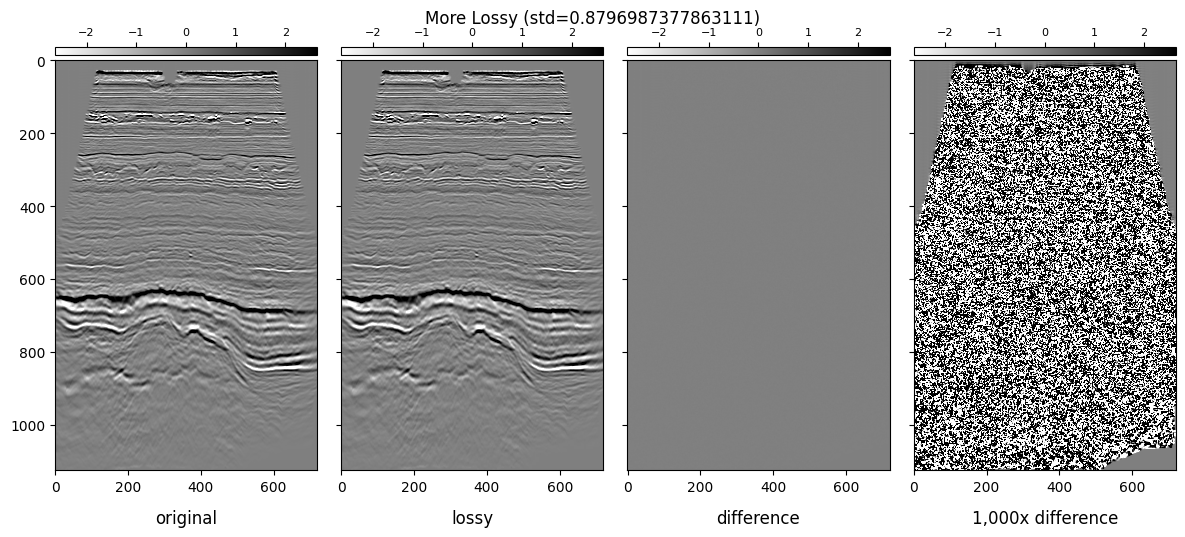

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

vmin = -3 * std
vmax = 3 * std

imshow_kw = dict(vmin=vmin, vmax=vmax, cmap="gray_r", interpolation="bilinear")


def attach_colorbar(image, axis):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("top", size="2%", pad=0.05)
    plt.colorbar(image, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.tick_params(labelsize=8)


def plot_image_and_cbar(data, axis, title):
    image = axis.imshow(data.T, **imshow_kw)
    attach_colorbar(image, axis)
    axis.set_title(title, y=-0.15)


def plot_inlines_with_diff(orig, compressed, title):
    fig, ax = plt.subplots(1, 4, sharey="all", sharex="all", figsize=(12, 5))

    diff = orig[200] - compressed[200]

    plot_image_and_cbar(orig[200], ax[0], "original")
    plot_image_and_cbar(compressed[200], ax[1], "lossy")
    plot_image_and_cbar(diff, ax[2], "difference")
    plot_image_and_cbar(diff * 1_000, ax[3], "1,000x difference")

    plt.suptitle(f"{title} ({std=})")
    fig.tight_layout()

    plt.show()


plot_inlines_with_diff(lossless, lossy, "Default Lossy")
plot_inlines_with_diff(lossless, lossy_plus, "More Lossy")

## Calculate Metrics

For image quality, there are some metrics used by the broader image compression community.

In this example we will be using the following four metrics as comparison.

1. PSNR: Peak signal-to-noise ratio for an image. (higher is better)
2. SSIM: Mean structural similarity index between two images. (higher is better, maximum value is 1.0)
3. MSE: Compute the mean-squared error between two images. (lower is better)
4. NRMSE: Normalized root mean-squared error between two images. (lower is better)

For PSNR or SSIM, we use the global dataset range `(max - min)` as the normalization method.

In image compression community, a PSNR value above 60 dB (decibels) is considered acceptable.

We calculate these metrics on the same inline we show above.

In [8]:
import skimage


def get_metrics(image_true, image_test):
    """Get four metrics"""
    psnr = skimage.metrics.peak_signal_noise_ratio(
        image_true[200], image_test[200], data_range=max_ - min_
    )
    ssim = skimage.metrics.structural_similarity(
        image_true[200], image_test[200], data_range=max_ - min_
    )
    mse = skimage.metrics.mean_squared_error(image_true[200], image_test[200])
    nrmse = skimage.metrics.normalized_root_mse(image_true[200], image_test[200])

    return psnr, ssim, mse, nrmse


print("Lossy", get_metrics(lossless, lossy))
print("Lossy+", get_metrics(lossless, lossy_plus))

Lossy (106.69280984265322, 0.9999999784224242, 9.176027503792131e-08, 0.000330489434736117)
Lossy+ (66.27609586061718, 0.999721336954417, 0.0010100110026414078, 0.0346731484815586)
